# A Pairs Trading strategy 

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# just set the seed for the random number generator
np.random.seed(107)

In [2]:
ticker_path = "data/etfs/pickle/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [5]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [6]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [7]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')

In [8]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2014',
                                                             '31-12-2016'),
                                                            ('01-01-2017',
                                                             '31-12-2017'),
                                                            remove_nan=True)

Total of 116 tickers
Total of 116 tickers after removing tickers with Nan values


In [9]:
len(df_prices_train)+len(df_prices_test)

78258

# Load Pairs

In [10]:
#with open('data/etfs/pickle/2014-2018/pairs_unsupervised_learning_optical_intraday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

with open('data/etfs/pickle/2014-2018/pairs_unsupervised_learning_optical_intraday_p005_seed12.pickle',
          'rb') as handle:
    pairs = pickle.load(handle)

In [12]:
len(pairs)

18

# Apply trading strategies

**Applying the fixed beta strategy in validation period**

In [13]:
train_val_split = '2016-01-01'

# intraday
n_years_val = round(len(df_prices_train[train_val_split:])/(240*78))

# interday
#n_years_val = round(len(df_prices_train)/(240))

n_years_val

1

In [14]:
train_results_without_costs, train_results_with_costs, performance_threshold_train = \
        trader.apply_trading_strategy(pairs, 
                                       'fixed_beta',
                                        2,#entry_multiplier,
                                        0,#exit_multiplier,
                                        test_mode=False,
                                        train_val_split=train_val_split
                                       )

sharpe_results_threshold_train_nocosts, cum_returns_threshold_train_nocosts = train_results_without_costs
sharpe_results_threshold_train_w_costs, cum_returns_threshold_train_w_costs = train_results_with_costs

 entry delay turned on.
Pair: 18/18

Average SR:  1.3808105295678355
Annual ROI:  12.645033042325826
88.88888888888889 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  4.6880044602233415
Autocorrelation:  0.08206957921871934
Daily Sharpe Ratio 0.27743696376169014
Total number of trades:  57
Positive trades:  45
Negative trades:  12
Max DD period: 6.0 days
Maximum drawdown of portfolio: -39.26%


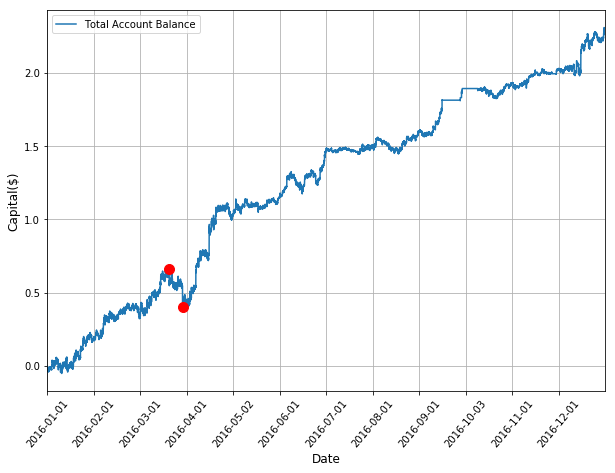

In [17]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_train_w_costs,
                                                  cum_returns_threshold_train_w_costs,
                                                  performance_threshold_train,
                                                  pairs, ticker_segment_dict,
                                                  n_years_val)

In [18]:
print('Corrected Annualized SR: {:.2f}'.format(0.2774369637616901*14.31))

Corrected Annualized SR: 3.97


Sharpe Ratio Distribution: 


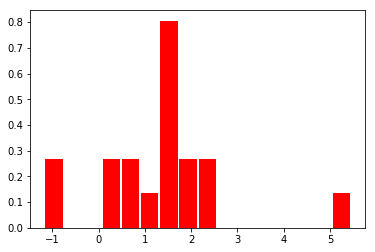

In [19]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_threshold_train_w_costs, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

In [20]:
#cum_returns_threshold_train_w_costs

In [21]:
betas = list()
for i in range(len(pairs)):
    betas.append(pairs[i][2]['coint_coef'])
np.asarray(betas)

array([0.54757155, 0.55939925, 0.35249098, 0.35973865, 2.10129361,
       0.87699079, 1.63886871, 0.46345674, 0.64037762, 0.14585009,
       0.42256502, 0.73810377, 1.48650978, 1.70100894, 0.2235903 ,
       1.63312741, 1.10309811, 1.10015149])

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [22]:
# intraday
n_years_test = round(len(df_prices_test)/(240*78))

# interday
#n_years_test = round(len(df_prices_test)/(240))

n_years_test

1

### Approach 1: Unrestricted

**Basic Threshold Strategy**

In [23]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 18/18

Average SR:  0.7864889962935588
Annual ROI:  7.361845564008251
77.77777777777777 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  3.164354265528854
Autocorrelation:  0.09242406173311411
Daily Sharpe Ratio 0.19214812142034185
Total number of trades:  24
Positive trades:  21
Negative trades:  3
Max DD period: 4.0 days
Maximum drawdown of portfolio: -34.06%


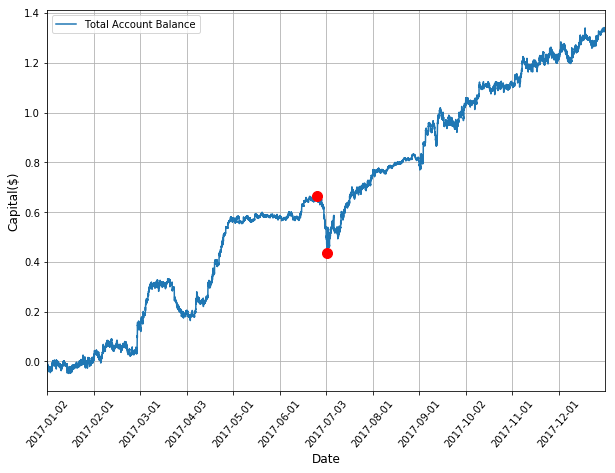

In [24]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  pairs, ticker_segment_dict,
                                                  n_years_test)

In [25]:
print('Corrected Annualized SR: {:.2f}'.format(0.19214812142034185*14.31))

Corrected Annualized SR: 2.75


### Approach 2: Keeping only pairs that had positive returns in the training period

In [26]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
profitable_pairs_indices = np.argwhere(cum_returns_threshold_train_w_costs > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [27]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(profitable_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 16/16

Average SR:  0.9288459930190304
Annual ROI:  8.375118949901218
81.25 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  3.274186631716568
Autocorrelation:  0.08327208120129659
Daily Sharpe Ratio 0.19792596178007582
Total number of trades:  22
Positive trades:  20
Negative trades:  2
Max DD period: 4.0 days
Maximum drawdown of portfolio: -33.31%


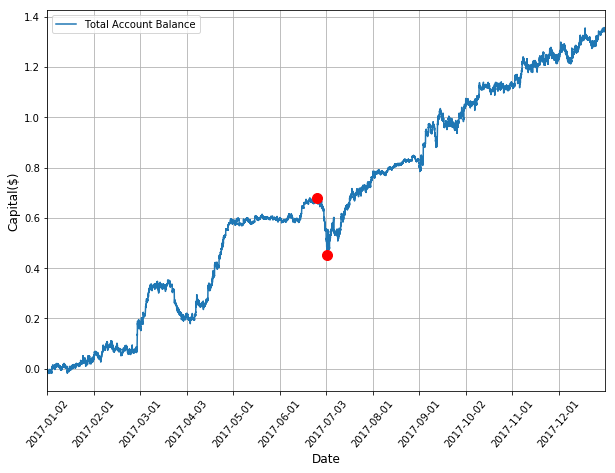

In [28]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years_test)

In [29]:
print('Corrected Annualized SR: {:.2f}'.format(0.19792596178007582*14.31))

Corrected Annualized SR: 2.83


### Approach 3: Keeping only top 10 pairs

In [30]:
sharpe_results_threshold_train_w_costs = np.asarray(sharpe_results_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(sharpe_results_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [31]:
# sorting by returns seems to give better results

In [32]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(cum_returns_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [33]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(top_10_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 10/10

Average SR:  1.0701508074091732
Annual ROI:  9.98129522059732
100.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  2.6370108345185397
Autocorrelation:  0.10215430595489129
Daily Sharpe Ratio 0.15871750449593516
Total number of trades:  17
Positive trades:  17
Negative trades:  0
Max DD period: 5.0 days
Maximum drawdown of portfolio: -49.03%


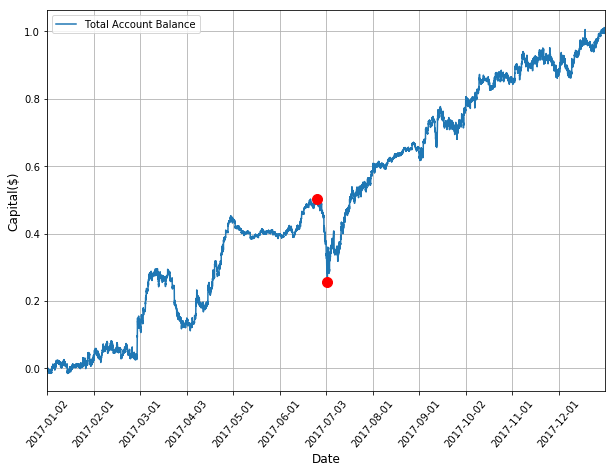

In [34]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  top_10_pairs, ticker_segment_dict,
                                                  n_years_test)

In [35]:
print('Corrected Annualized SR: {:.2f}'.format(0.15871750449593516*14.31))

Corrected Annualized SR: 2.27


# Validate the results

In [30]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,UGA,Commodities: Energy Gasoline,BNO,Commodities: Energy Crude Oil,-2.918676,0.043219,541,979,0.428580,4,0,3.640048,100.0
1,CORN,Commodities: Agriculture Corn,WEAT,Commodities: Agriculture Wheat,-4.256209,0.000529,795,430,0.407697,2,0,1.189459,100.0
2,DBA,Commodities: Agriculture,WEAT,Commodities: Agriculture Wheat,-3.050351,0.030452,209,1618,0.428102,2,0,1.157020,100.0
3,PXI,Equity: U.S. Energy,RYE,Equity: U.S. Energy,-3.341843,0.013109,946,203,0.275947,1,0,1.024430,100.0
4,DGP,Leveraged Commodities: Precious Metals Gold,SIVR,Commodities: Precious Metals Silver,-3.162652,0.022251,480,1062,0.438867,2,0,1.000441,100.0
5,DGP,Leveraged Commodities: Precious Metals Gold,SLV,Commodities: Precious Metals Silver,-3.174225,0.021526,450,1131,0.442630,2,0,0.966071,100.0
6,PHO,Equity: Global Water,YMLI,Equity: U.S. MLPs,-3.499132,0.008009,458,811,0.422755,1,0,0.664726,100.0
7,GCC,Commodities: Broad Market,USCI,Commodities: Broad Market,-2.978461,0.036955,627,497,0.320522,1,0,0.441988,100.0
8,UGL,Leveraged Commodities: Precious Metals Gold,SIVR,Commodities: Precious Metals Silver,-3.440646,0.009649,342,998,0.453641,1,0,0.310700,100.0
9,SLV,Commodities: Precious Metals Silver,UGL,Leveraged Commodities: Precious Metals Gold,-3.479728,0.008523,374,1044,0.457049,1,0,0.306626,100.0
